Multifrequency and Doppler Radar Example
====================================

If this is not what you are looking for go back to the [list of notebooks](../simple_usage.rst)

In this example we will look at the multifrequency spectrum calculator first. And then we will derive the multifrequency (X-Ka-W) characteristic of some particles included in snowScatt by assuming an inverse exponential Particle Size Distribution (PSD)

Multifrequency Doppler
===================


Initialize the calculations by loading some basic modules. And define some useful functions.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
begin = datetime.datetime.now()

import snowScatt

from snowScatt.instrumentSimulator.radarMoments import Ze
from snowScatt.instrumentSimulator.radarSpectrum import dopplerSpectrum
from snowScatt.instrumentSimulator.radarSpectrum import sizeSpectrum


def Nexp(D, lam):
    return np.exp(-lam*D)/lam # basic implementation of an inverse exponential size distribution

def dB(x):
    return 10.0*np.log10(x)

def Bd(x):
    return 10.0**(0.1*x)

Set the parameters of the calculation. The frequencies (in Herz), the vector of sizes for which the snow properties (backscatter, fallspeed and concentration) are gonna be calculated.
Set additional parameters for the computation

Execution  0:00:00.566509


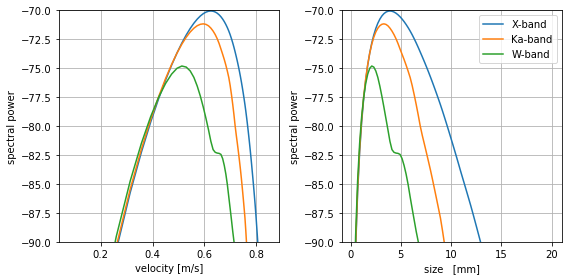

In [2]:
frequency =  np.array([9.6e9, 35.6e9, 94.0e9]) # frequencies
freq_label =  ['X-band', 'Ka-band', 'W-band'] # frequencies
temperature = 270.0

Dmax = np.linspace(0.1e-3, 20.0e-3, 100) # list of sizes [meters]
lams = 1.0/1.0e-3 # lambda parameters of the PSD [meters**-1]

particle = 'Leinonen15tabA00'
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
concentration = 1000.0 # number m**-1 m**-3
PSD = (concentration*(np.array(Nexp(Dmax, lams))))[np.newaxis, ...]

for idf, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq
    spec0, vel = dopplerSpectrum(Dmax, PSD, wl, particle, temperature=temperature)
    spec1 = sizeSpectrum(Dmax, PSD, wl, particle, temperature=temperature)

    Zx = Ze(Dmax, PSD, wl, particle, temperature=temperature)

    ax0.plot(vel, dB(spec0[0, :]*np.gradient(vel)))
    ax1.plot(Dmax*1.0e3, dB(spec1[0, :]*np.gradient(Dmax)), label=freq_label[idf])
for ax in (ax0, ax1):
    ax.grid()
    ax.set_ylabel('spectral power')
    ax.set_ylim([-90, -70])
ax1.legend()
ax0.set_xlabel('velocity [m/s]')
ax1.set_xlabel('size   [mm]')
fig.tight_layout()
print('Execution ', datetime.datetime.now()-begin)

Z0 = dB(np.nansum((spec0*np.gradient(vel)), axis=-1))
Z1 = dB(np.nansum((spec1*np.gradient(Dmax)), axis=-1)) # chack that Z0 and Z1 are equal

Triple-Frequency Signature
======================
In this example we will assume a series of inverse exponential PSDs with different scale parameters lambda.
We will analyze how the multifrequency radar signature varies as a function of lambda for different particle types. In particular we will use Leinonen and Szyrmer subsequent riming model (B) with various ELWP values and also some particles from Ori et al. (2014) for comparison purposes

Execution  0:00:04.699611


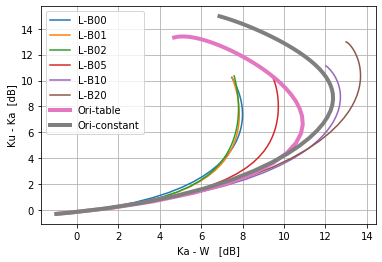

In [3]:
frequency =  np.array([13.6e9, 35.6e9, 94.0e9]) # frequencies
temperature = 270.0
Nangles = 721

Dmax = np.linspace(0.1e-3, 20.0e-3, 1000) # list of sizes
lams = 1.0/np.linspace(0.01e-3, 11.0e-3, 100)

rime = ['00', '01', '02', '05', '10', '20']
particles = 'Leinonen15tabB'
fig, (ax0) = plt.subplots(1, 1)
# 
PSD = np.stack([np.array(Nexp(Dmax, l)) for l in lams])
for r in rime:
    particle = particles + r
    bck = pd.DataFrame(index=Dmax, columns=frequency)
    for fi, freq in enumerate(frequency):
        wl = snowScatt._compute._c/freq
        eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
        K2 = snowScatt.refractiveIndex.utilities.K2(eps)
        ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                              wavelength=wl,
                                              properties=particle,
                                              temperature=temperature)
        bck[freq] = wl**4*ssCbck/(K2*np.pi**5)

    Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
    
    ax0.plot(Zk-Zw, Zx-Zk, label='L-B'+r)

particle = 'Ori_collColumns' # This is from Ori et al (2014). SSRGA parameters are derived from size resolved tables with 1 mm resolution
bck = pd.DataFrame(index=Dmax, columns=frequency)
for fi, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq
    eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
    K2 = snowScatt.refractiveIndex.utilities.K2(eps)
    ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                          wavelength=wl,
                                          properties=particle,
                                          temperature=temperature)
    bck[freq] = wl**4*ssCbck/(K2*np.pi**5)
Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
ax0.plot(Zk-Zw, Zx-Zk, label='Ori-table', lw=4)

particle = 'Oea14' # This is also from Ori et al. 2014 but this time we do not consider the size-dependent evolution of the SSRGA parameters. 
# The effect of monomers at small sizes and initial stages of aggregation will impact the multifrequency signature
bck = pd.DataFrame(index=Dmax, columns=frequency)
for fi, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq
    eps = snowScatt.refractiveIndex.water.eps(temperature, freq, 'Turner')
    K2 = snowScatt.refractiveIndex.utilities.K2(eps)
    ssCbck, ssvel = snowScatt.backscatVel(diameters=Dmax,
                                          wavelength=wl,
                                          properties=particle,
                                          temperature=temperature)
    bck[freq] = wl**4*ssCbck/(K2*np.pi**5)
Zx = np.array([dB((1.0e18*bck.iloc[:, 0]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zk = np.array([dB((1.0e18*bck.iloc[:, 1]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
Zw = np.array([dB((1.0e18*bck.iloc[:, 2]*Nexp(Dmax, l)*np.gradient(Dmax)).sum()) for l in lams ])
ax0.plot(Zk-Zw, Zx-Zk, label='Ori-constant', lw=4)

for ax in [ax0,]:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Ka - W   [dB]')
    ax.set_ylabel('Ku - Ka  [dB]')
fig.savefig('triple_frequency.png', dpi=300)
print('Execution ', datetime.datetime.now()-begin)

Go back to the [list of notebooks](../simple_usage.rst) for further snowScatt examples